In [8]:
import os

import parselmouth

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import IPython.display
from scipy.io import wavfile

In [2]:
sns.set() # Use seaborn's default style to make attractive graphs

# Plot nice figures using Python's "standard" matplotlib library
snd = parselmouth.Sound("male_a_spa.wav")
# fig = plt.figure()
# axes = fig.gca()
# axes.plot(snd.xs(), snd.values.T)
# axes.set_xlim([snd.xmin, snd.xmax])
# axes.set_xlabel("time [s]")
# axes.set_ylabel("amplitude")


In [3]:

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

# intensity = snd.to_intensity()
# spectrogram = snd.to_spectrogram()
# plt.figure()
# draw_spectrogram(spectrogram)
# plt.twinx()
# draw_intensity(intensity)
# plt.xlim([snd.xmin, snd.xmax])

In [4]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
# pre_emphasized_snd = snd.copy()
# pre_emphasized_snd.pre_emphasize()
# spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
# plt.figure()
# draw_spectrogram(spectrogram)
# plt.twinx()
# draw_pitch(pitch)
# plt.xlim([snd.xmin, snd.xmax])



In [5]:
formants = snd.to_formant_burg()

f1 = list()
f2 = list()
for t in formants.t_grid():
    f1.append(formants.get_value_at_time(1,t))
    f2.append(formants.get_value_at_time(2,t))

# pre_emphasized_snd = snd.copy()
# pre_emphasized_snd.pre_emphasize()
# spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
# plt.figure()
# # draw_spectrogram(spectrogram)
# intensity = snd.to_intensity()
# draw_intensity(intensity)
# plt.twinx()
# plt.plot(formants.t_grid(), f1)
# plt.hlines(1000, 0, formants.t_grid()[-1])
# plt.plot(formants.t_grid(), f2)
# plt.hlines(1400, 0, formants.t_grid()[-1])
# plt.twinx()
# plt.plot(snd.xs(), snd.values.T,  alpha=0.5, color='g')
# plt.xlim([snd.xmin, snd.xmax])
# plt.xlabel("time [s]")
# plt.ylabel("amplitude")

observed_formants = {'a': [682.845033143518, 1347.6680693901671],
 'e': [494.84181512897976, 1619.9787143718208],
 'i': [382.33315846211553, 1657.3348620074385],
 'o': [506.2493853362084, 1101.1472533066992],
 'u': [434.7785079520296, 984.1856223625758]}

observed_formants_std = {'a': [73.7791520366105, 93.04641134935628],
 'e': [55.49710196672828, 132.8479221603176],
 'i': [50.65527125493847, 155.24836087654543],
 'o': [60.20226523820195, 170.6404810742714],
 'u': [50.328755387520836, 193.66177958793827]}

vowel_colors = {
    'a': 'r',
    'e': 'c',
    'i': 'm',
    'o': 'y',
    'u': 'g',
}

def extract_f1_f2_and_intensity_from_sound(snd):
    formants = snd.to_formant_burg()
    intensity = snd.to_intensity()
    f1 = list()
    f2 = list()
    intensity_list = list()
    for t in formants.t_grid():
        f1.append(formants.get_value_at_time(1,t))
        f2.append(formants.get_value_at_time(2,t))
        intensity_list.append(intensity.get_value(t))

    return f1, f2, intensity_list, formants.t_grid()

def get_closer_vowel(f1, f2, theoretical_formants=observed_formants):
    return min(
        map(
            lambda x:
                (x[0], abs(x[1] - f1) + abs(x[2] - f2)),
            ((vowel, t_f1, t_f2) for vowel, (t_f1, t_f2) in theoretical_formants.items())
        ),
        key=lambda x: x[1]
    )

def evaluate_non_vocal(vowel_and_distance, observed_std=observed_formants_std):
    vowel, distance = vowel_and_distance
    if distance > sum(observed_std[vowel]):
        return (f'non_vocal_{vowel}', distance)
    return vowel_and_distance

In [6]:
transcription = "a"
base_folder = "all_spanish_letters_recordings/aphasia_wav"
file_name = "aphasia/24418.mp4"

formants_dir = "all_formants_observed_formants"
os.makedirs(formants_dir, exist_ok=True)

wav_filename = file_name.replace(".mp4", ".wav")
snd = parselmouth.Sound(os.path.join(base_folder, wav_filename))

In [7]:
def apply_intensity_filter(intensity, signal, threshold=40):
    np_intensity = np.array(intensity)
    return np.where(np_intensity > threshold, signal, -1)

def vowels_in_transcription(transcription):
    allowed_vowels = "aeiou"
    return set([x for x in transcription if x in allowed_vowels])

<ipython-input-7-e495df0c981e>:3: RuntimeWarning: invalid value encountered in greater
  return np.where(np_intensity > threshold, signal, -1)


<class 'numpy.ndarray'>
(24576, 1)


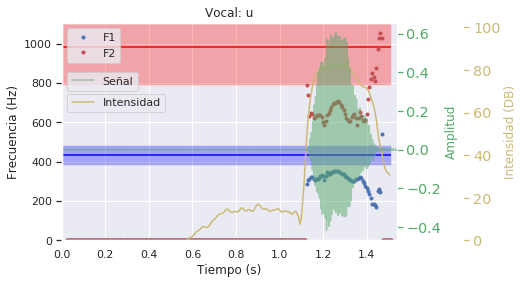

In [124]:
def plot_snd_with_all(snd, transcription, file_name, folder=formants_dir):
    f1, f2, intensity_list, t = extract_f1_f2_and_intensity_from_sound(snd)
    fig, host = plt.subplots()
    plt.title(f"Vocal: {transcription}")
    # show formants
    time_array = np.array(t)
    host.plot(time_array, apply_intensity_filter(intensity_list, f1), '.', color='b', label = 'F1')
    host.plot(time_array, apply_intensity_filter(intensity_list, f2), '.', color='r', label = 'F2')
    host.set_ylim(0)
    host.set_ylabel('Frecuencia (Hz)')
    host.legend(loc="upper left")
    host.set_xlabel('Tiempo (s)')
    for letter in vowels_in_transcription(transcription):
        host.add_patch(
            Rectangle(
                (0, observed_formants[letter][0] - observed_formants_std[letter][0]),
                time_array[-1],
                observed_formants_std[letter][0]*2,
                alpha=0.3,
                facecolor='blue'
            )

        )
        host.add_patch(
            Rectangle(
                (0, observed_formants[letter][1] - observed_formants_std[letter][1]),
                time_array[-1],
                observed_formants_std[letter][1]*2,
                alpha=0.3,
                facecolor='red'
            )

        )
        plt.hlines(observed_formants[letter][0], 0, time_array[-1], color='blue')
        # plt.hlines(observed_formants[letter][0] + observed_formants_std[letter][0], 0, time_array[-1], color=vowel_colors[letter])
        # plt.hlines(observed_formants[letter][0] - observed_formants_std[letter][0], 0, time_array[-1], color=vowel_colors[letter])

        plt.hlines(observed_formants[letter][1], 0, time_array[-1], color='red')
        # plt.hlines(observed_formants[letter][1] + observed_formants_std[letter][0], 0, time_array[-1], color=vowel_colors[letter])
        # plt.hlines(observed_formants[letter][1] - observed_formants_std[letter][0], 0, time_array[-1], color=vowel_colors[letter])

     # Plot intensity
    par_intensity = host.twinx()
    par_intensity.spines["right"].set_position(("axes", 1.2))
    par_intensity.tick_params(axis='y', labelright=True, colors='y', labelsize='large')
    par_intensity.plot(time_array, intensity_list, color='y', label='Intensidad')

    par_intensity.set_ylim(0)
    par_intensity.legend(loc='upper left', bbox_to_anchor=(0,0.7),)
    par_intensity.set_ylabel('Intensidad (DB)')
    par_intensity.yaxis.label.set_color("y")
    par_intensity.grid(False)

    # Plot signal
    par_signal = host.twinx()
    print(type(snd.values.T))
    print(snd.values.T.shape)
    par_signal.plot(snd.xs(), snd.values[-1].T,  alpha=0.5, color='g', label='Señal')
    par_signal.set_xlim([snd.xmin, snd.xmax])
    # par_signal.yaxis.set_label_position("left")
    par_signal.set_ylabel('Amplitud')
    par_signal.yaxis.label.set_color("g")
    par_signal.tick_params(axis='y', colors='g', labelsize='large')
    # par_signal.set_yticks([])
    par_signal.legend(bbox_to_anchor=(0,0.8), loc="upper left")
    par_signal.grid(False)

    plt.savefig(os.path.join(folder, f"_{file_name}-{transcription}-new.png"), bbox_inches = "tight")

# file_name = "aphasia/24418.mp4"  # a
# file_name = "aphasia/25479.mp4"  # e
# file_name = "aphasia/24697.mp4"  # i
# file_name = "aphasia/26366.mp4"  # o
file_name = "aphasia/36639.mp4"  # u

wav_filename = file_name.replace(".mp4", ".wav")
snd = parselmouth.Sound(os.path.join(base_folder, wav_filename))
plot_snd_with_all(snd, "u", "36639")

In [114]:
snd.values[0].shape

(19797,)

In [88]:
file_name = "all_spanish_letters_recordings/aphasia_letters.txt"
with open(file_name) as f:
    all_recordings = f.readlines()
# all_recordings


Record file all_spanish_letters_recordings/aphasia_wav/aphasia/24410.wav does not exists
aphasia/24410.wav a
Plotting  a
aphasia/24418.wav a
Plotting  a
aphasia/24689.wav a
Plotting  a
aphasia/24740.wav a
Plotting  a
aphasia/25130.wav a
Plotting  a
aphasia/25144.wav a
Plotting  a
aphasia/25475.wav a
Plotting  a
aphasia/26352.wav a
Plotting  a
aphasia/26400.wav a
Plotting  a
aphasia/26597.wav a
Plotting  a
aphasia/26604.wav a
Plotting  a
aphasia/32053.wav a
Plotting  a
aphasia/36558.wav a
aphasia/24416.wav be
aphasia/24690.wav be
aphasia/24741.wav be
aphasia/25131.wav be
aphasia/25145.wav be
aphasia/25476.wav be
aphasia/26353.wav be
aphasia/26401.wav be
aphasia/26598.wav be
aphasia/32054.wav be
aphasia/36559.wav be
aphasia/24417.wav ce
aphasia/24691.wav ce
aphasia/24742.wav ce
aphasia/25132.wav ce
aphasia/25146.wav ce
aphasia/25477.wav ce
aphasia/26354.wav ce
aphasia/26402.wav ce
aphasia/26599.wav ce
aphasia/32055.wav ce
aphasia/36560.wav ce
aphasia/24420.wav de
aphasia/24692.wav de
aph

<ipython-input-7-e495df0c981e>:3: RuntimeWarning: invalid value encountered in greater
  return np.where(np_intensity > threshold, signal, -1)
<ipython-input-87-0ad4b474de4d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, host = plt.subplots()


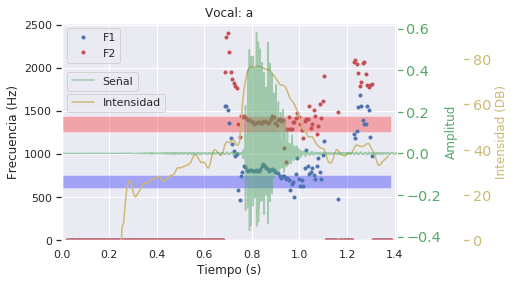

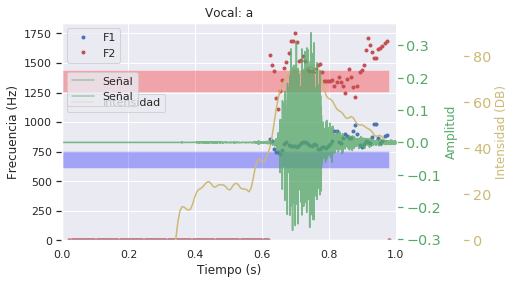

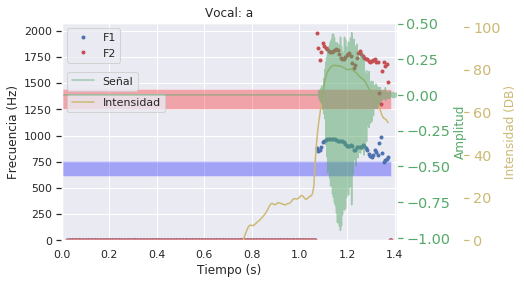

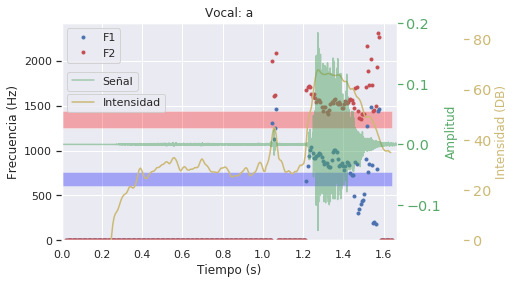

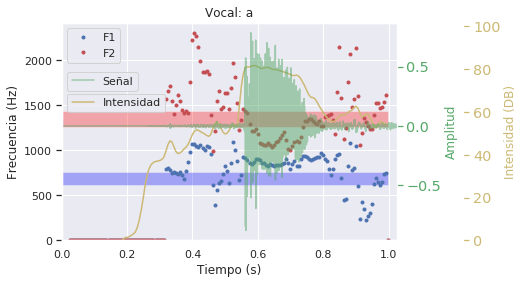

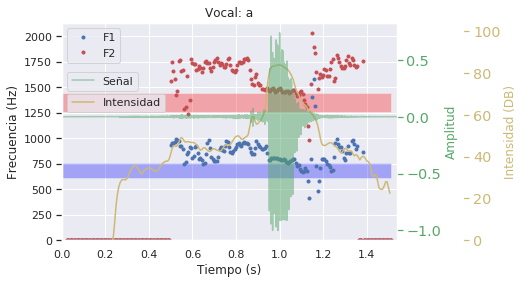

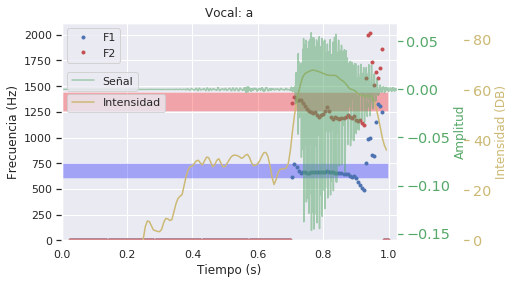

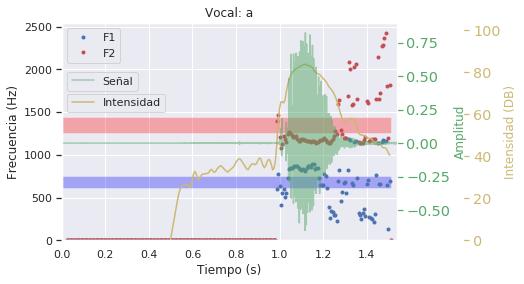

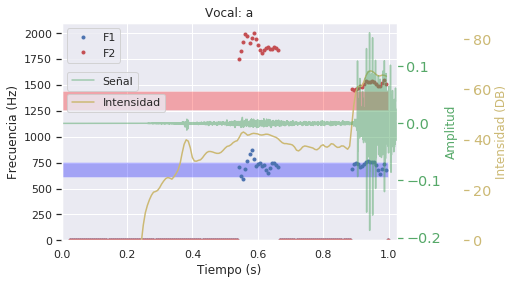

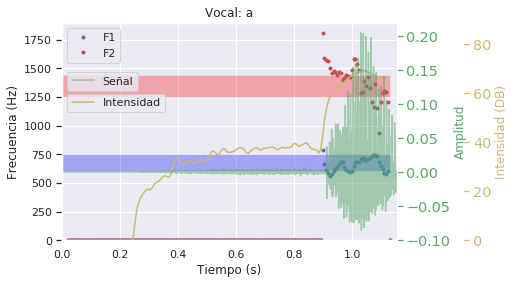

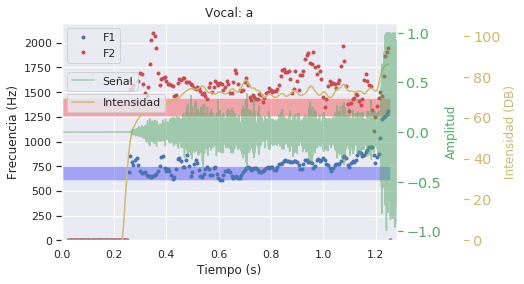

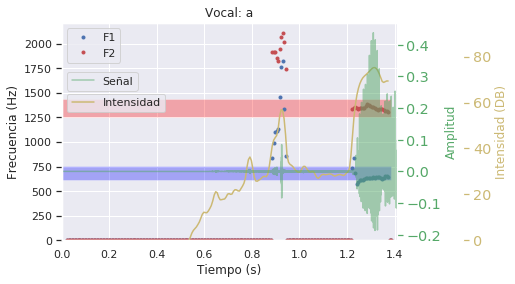

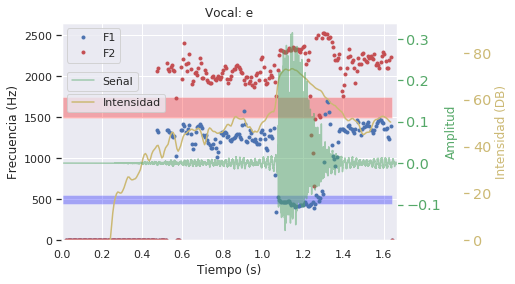

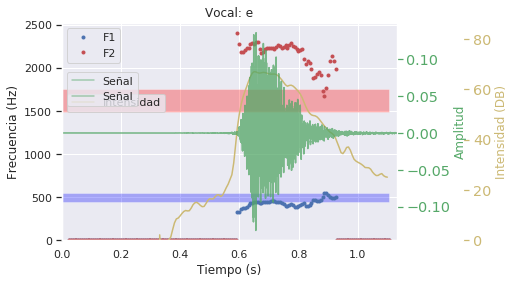

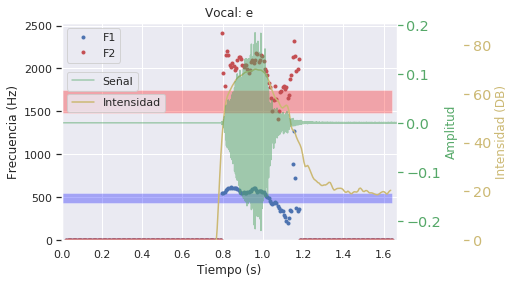

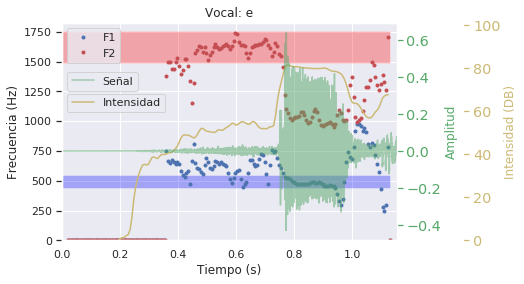

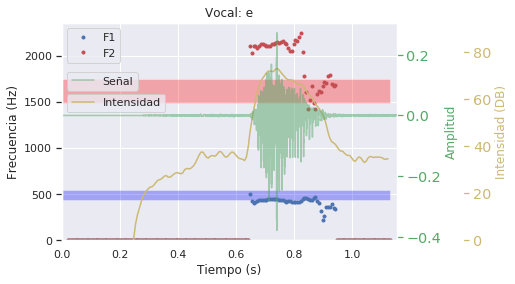

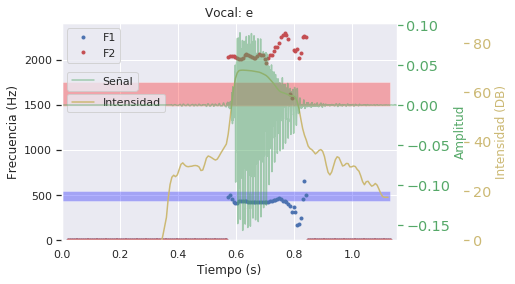

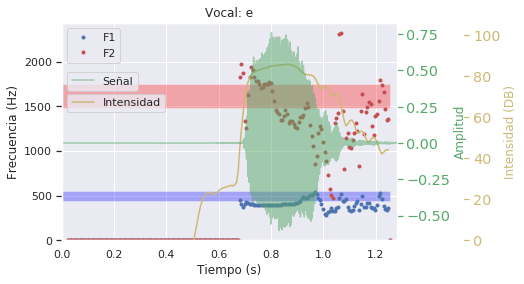

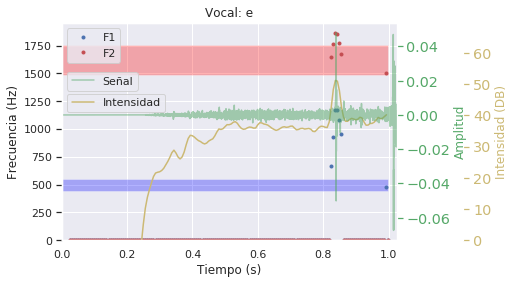

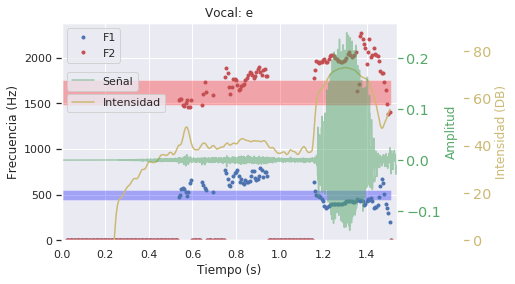

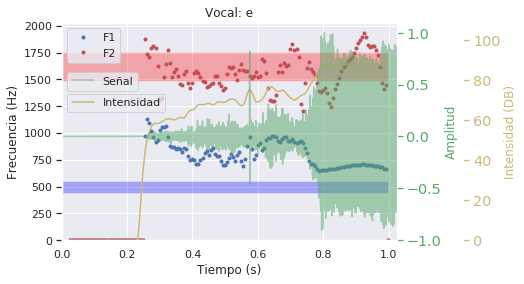

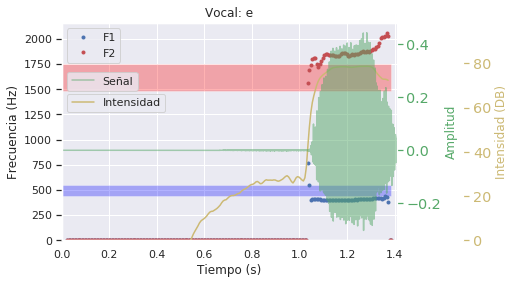

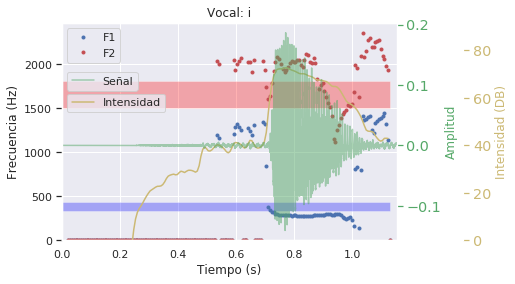

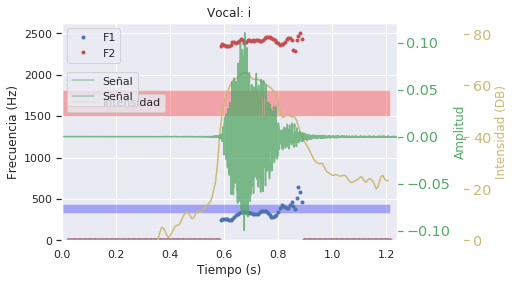

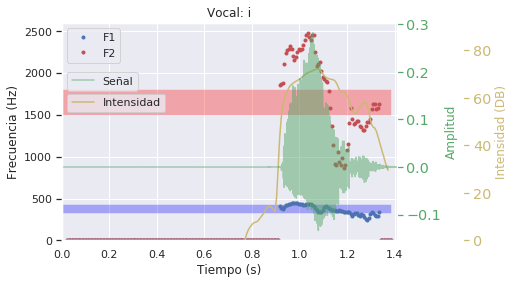

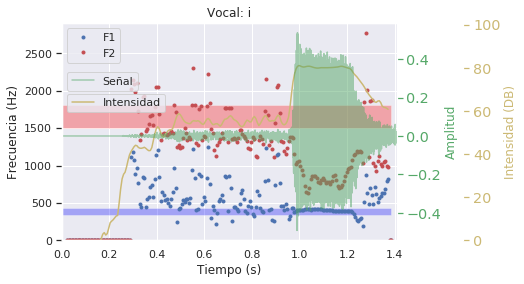

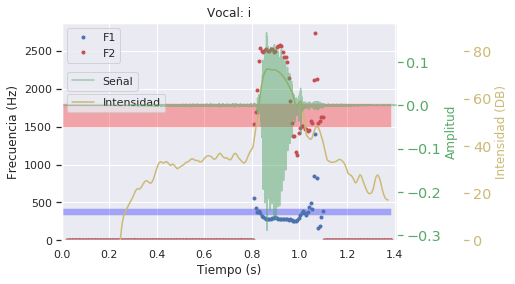

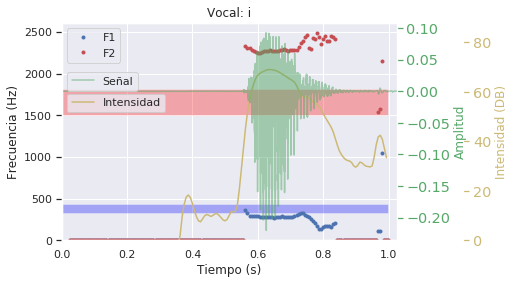

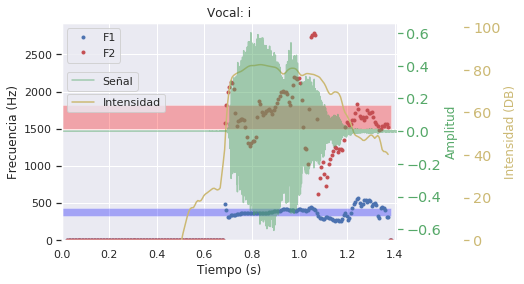

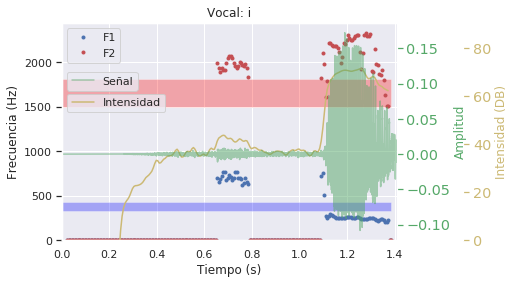

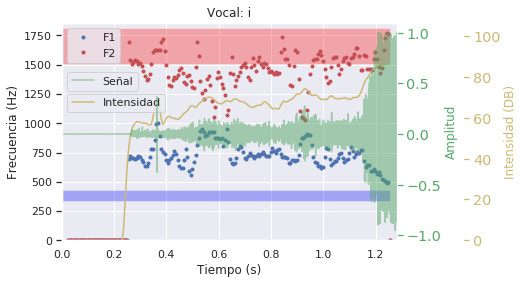

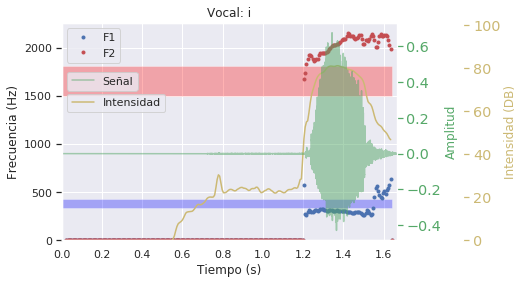

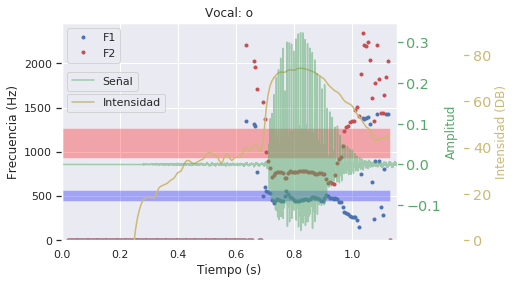

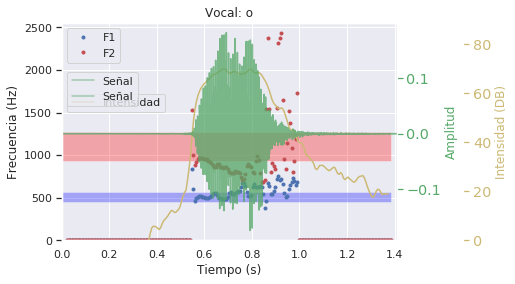

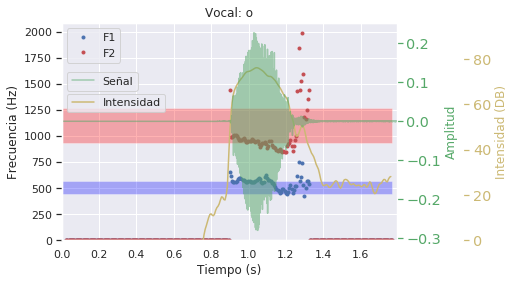

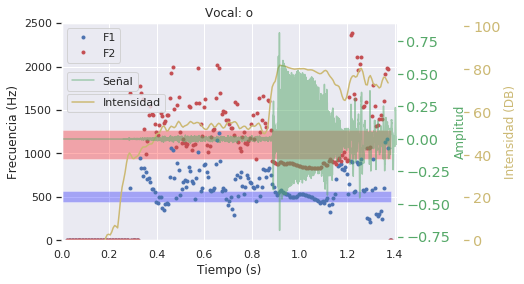

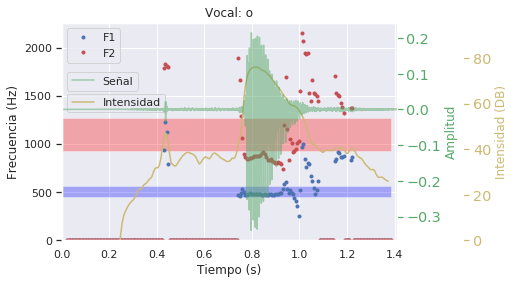

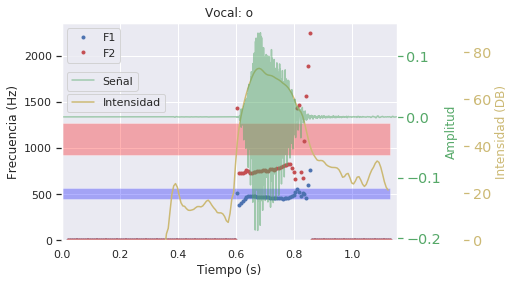

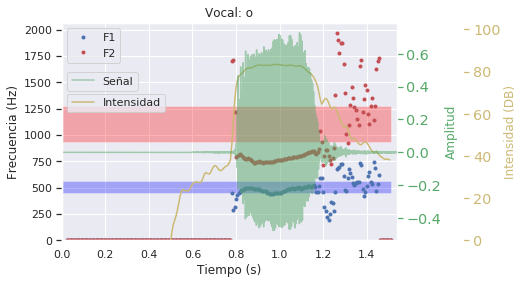

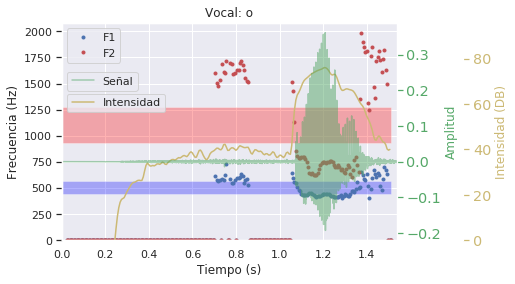

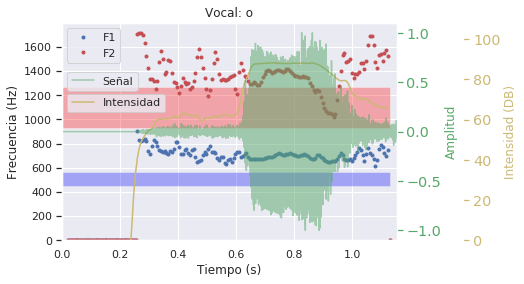

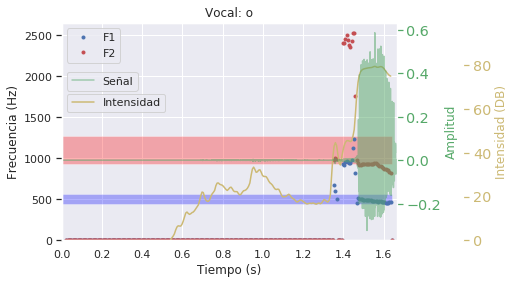

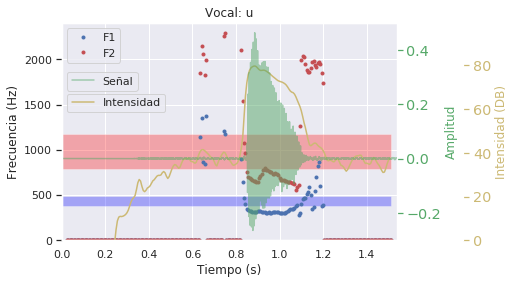

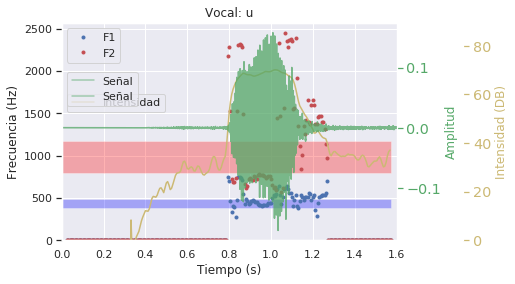

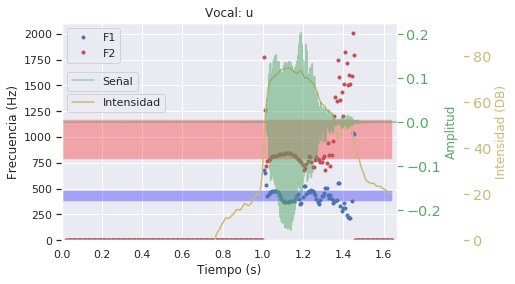

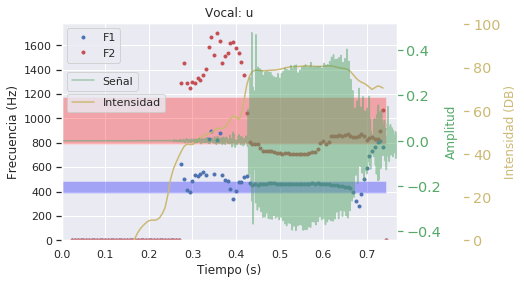

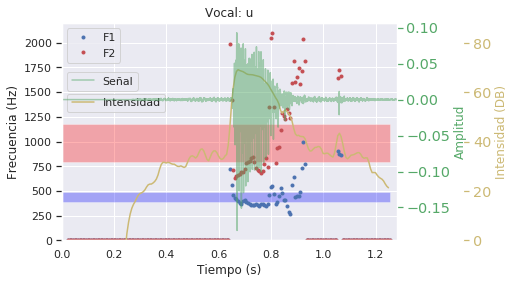

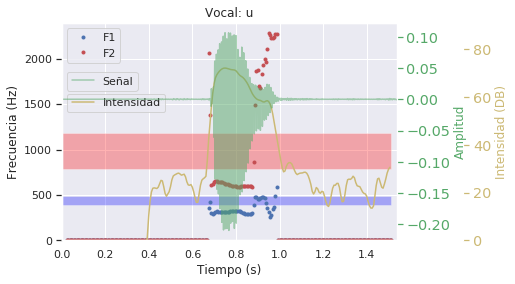

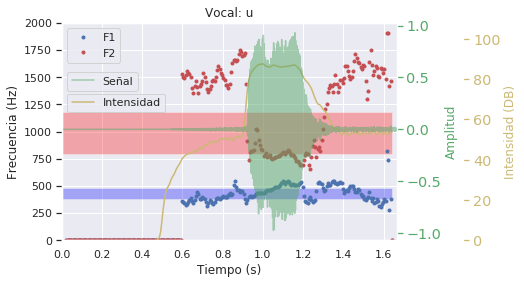

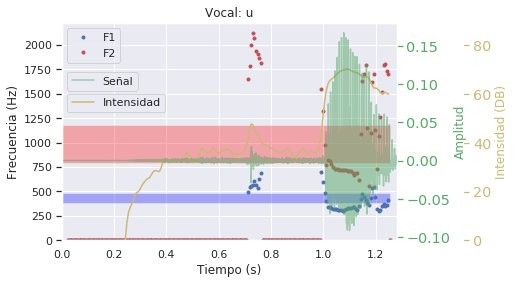

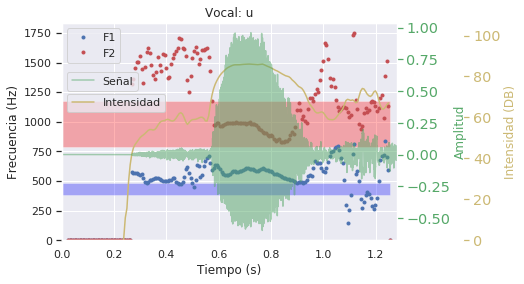

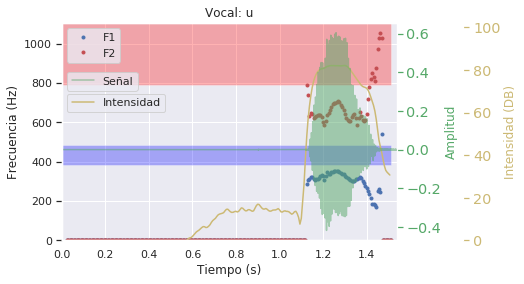

In [89]:

for record in all_recordings:
    record_name, transcription = record.replace("mp4", "wav").replace("\n", "").split(",")
    record_path = os.path.join(base_folder, record_name)
    record_number = record_name.replace('.wav', '').split('/')[-1]
    transcription_file_path = os.path.join(formants_dir, f"{record_number}-{transcription}.csv")
    if os.path.exists(record_path):
        snd = parselmouth.Sound(record_path)
        if transcription.strip() in "aeiou":
            print("Plotting ", transcription)
            plot_snd_with_all(snd, transcription, record_number)
    else:
        print(f"Record file {record_path} does not exists")
    print(record_name, transcription)